In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# plot settings
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [2]:
# load the csv we created in notebook 02
data_path = '../data/processed/merged_bearing_data.csv'
df = pd.read_csv(data_path, index_col='timestamp', parse_dates=True)

print(f"loaded dataset with shape: {df.shape}")
df.head()

loaded dataset with shape: (984, 5)


,rms,kurtosis,skewness,peak_to_peak,crest_factor
timestamp,,,,,
2004-02-12 10:32:39,0.074179,3.628763,0.083993,0.840,6.120331
2004-02-12 10:42:39,0.075382,3.648291,0.052142,0.757,5.147086
2004-02-12 10:52:39,0.076230,3.513475,0.032808,0.903,6.598472
2004-02-12 11:02:39,0.078724,4.157953,0.041486,1.184,7.723217
2004-02-12 11:12:39,0.078474,3.603177,0.028224,0.782,4.982524


training samples (healthy baseline): 196
testing samples (monitoring phase): 788


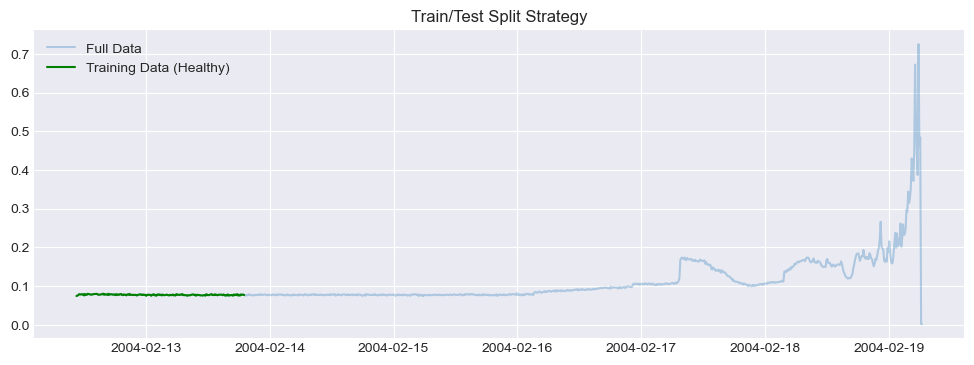

In [3]:
# logic: we assume the first 20% of the data is "healthy" because the experiment just started.
# we train the model ONLY on healthy data so it learns what "normal" looks like.
# anything different from this will be flagged as an anomaly.

train_size = int(len(df) * 0.20)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

print(f"training samples (healthy baseline): {len(train_data)}")
print(f"testing samples (monitoring phase): {len(test_data)}")

# visualize the split
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['rms'], label='Full Data', alpha=0.3)
plt.plot(train_data.index, train_data['rms'], label='Training Data (Healthy)', color='green')
plt.legend()
plt.title("Train/Test Split Strategy")
plt.show()

In [4]:
# models hate big numbers. scale everything to mean=0, std=1.
scaler = StandardScaler()

# fit on training data ONLY, then transform both
X_train = scaler.fit_transform(train_data)
X_test = scaler.transform(test_data)
X_full = scaler.transform(df) # for final plotting

# save the scaler for the API later
os.makedirs('../models', exist_ok=True)
joblib.dump(scaler, '../models/scaler.pkl')
print("scaler saved to models/scaler.pkl")

scaler saved to models/scaler.pkl


In [5]:
# isolation forest is perfect for this. it isolates outliers randomly.
# contamination=0.01 means we expect roughly 1% of the training data might be noise.

model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
model.fit(X_train)

# save the trained model
joblib.dump(model, '../models/iso_forest_model.pkl')
print("model trained and saved to models/iso_forest_model.pkl")

model trained and saved to models/iso_forest_model.pkl


In [6]:
# predict on the full dataset to see when it starts flagging failures
# -1 = anomaly (failure), 1 = normal
predictions = model.predict(X_full)

# calculate anomaly scores (lower score = more abnormal)
anomaly_scores = model.decision_function(X_full)

# add results to original dataframe for plotting
df['anomaly_pred'] = predictions
df['anomaly_score'] = anomaly_scores

# map -1 to 1 (failure) and 1 to 0 (normal) for easier plotting
df['is_anomaly'] = df['anomaly_pred'].apply(lambda x: 1 if x == -1 else 0)

print(df['is_anomaly'].value_counts())

is_anomaly
0    648
1    336
Name: count, dtype: int64


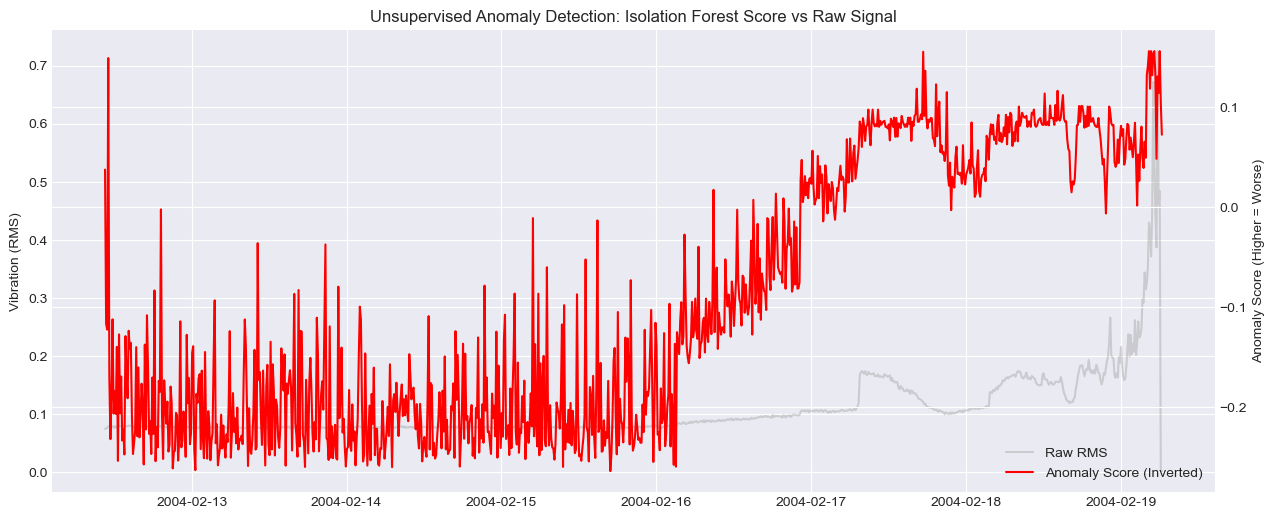

In [7]:
# plot the anomaly score over time
# when the score drops (or the inverted score spikes), that's the failure.

plt.figure(figsize=(15, 6))

# plot raw RMS in background
ax1 = plt.gca()
ax1.plot(df.index, df['rms'], color='gray', alpha=0.3, label='Raw RMS')
ax1.set_ylabel('Vibration (RMS)')

# plot anomaly probability on secondary axis
ax2 = ax1.twinx()
# we invert the score so spikes mean DANGER
ax2.plot(df.index, -df['anomaly_score'], color='red', label='Anomaly Score (Inverted)', linewidth=1.5)
ax2.set_ylabel('Anomaly Score (Higher = Worse)')

plt.title('Unsupervised Anomaly Detection: Isolation Forest Score vs Raw Signal')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()